<a href="https://colab.research.google.com/github/annaola/ZIwM/blob/master/ZIwM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Przygotowanie danych

In [1]:
pip install pandas_ods_reader

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_ods_reader import read_ods
from sklearn.feature_selection import SelectKBest, chi2
from scipy.stats import mode
# pd.options.display.max_columns = None

## Pobieranie danych

In [3]:
features = ["Koncentracja hemoglobiny", "Liczba erytrocytów", "Średnia objętość krwinki", "Średnie stężenie HB w krwince", "Wielkość erytrocytów", "Rodzaj erytrocytów", "Tkanka siateczkowata", "Szpik kostny", "Wielkość komórki", "Stosunek jądrowo-cytoplazmatyczny", "Rodzaj jądra", "Struktura chromatyny jądrowej", "Jąderko", "Pasożyty", "Ziarenka żelaza", "Poziom żelaza", "Poziom trwałych związków żelaza", "Poziom witaminy B", "Poziom kwasu foliowego", "Nieznana", "Reakcja odporonościowa", "Reakcja uro...", "Reakcja ruchliwości komórki", "Płeć", "Wiek", "Gorączka", "Krwawienie", "Skóra", "Węzły chłonne", "Szmery sercowe", "Wątroba, śledziona", "Klasa choroby"]
df = read_ods('./Anemia_dane/ANEMIA.ods', 1, columns=features)
df.astype(int)

,Koncentracja hemoglobiny,Liczba erytrocytów,Średnia objętość krwinki,Średnie stężenie HB w krwince,Wielkość erytrocytów,Rodzaj erytrocytów,Tkanka siateczkowata,Szpik kostny,Wielkość komórki,Stosunek jądrowo-cytoplazmatyczny,...,Reakcja ruchliwości komórki,Płeć,Wiek,Gorączka,Krwawienie,Skóra,Węzły chłonne,Szmery sercowe,"Wątroba, śledziona",Klasa choroby
0,2,2,1,1,1,1,3,1,1,1,...,1,1,2,1,2,1,1,2,2,1
1,1,1,1,1,1,5,2,1,1,1,...,1,2,1,1,2,1,1,2,2,1
2,4,2,2,1,1,2,2,1,1,1,...,2,1,2,1,2,1,1,2,2,1
3,5,1,1,2,2,1,3,1,1,2,...,2,2,2,1,2,1,2,2,2,1
4,3,1,1,1,1,4,2,2,1,2,...,1,2,1,1,2,1,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,4,1,2,2,3,5,3,1,2,2,...,1,2,3,2,2,1,1,2,2,20
406,4,1,3,1,3,1,2,1,1,2,...,1,2,2,2,1,1,1,2,1,20
407,5,5,1,1,3,6,1,5,2,2,...,1,1,1,2,2,1,1,2,2,20
408,5,2,3,1,2,7,1,1,1,1,...,2,2,6,2,2,1,1,2,2,20


## Podział danych na zbiór przykładów i ich klasy

In [4]:
training_set = df.loc[:, features[0]:features[30]]
classes = df.loc[:, features[31]]

### Rozkład wartosci cech dla wszystkich przykładów

In [5]:
training_set.describe()

,Koncentracja hemoglobiny,Liczba erytrocytów,Średnia objętość krwinki,Średnie stężenie HB w krwince,Wielkość erytrocytów,Rodzaj erytrocytów,Tkanka siateczkowata,Szpik kostny,Wielkość komórki,Stosunek jądrowo-cytoplazmatyczny,...,Reakcja uro...,Reakcja ruchliwości komórki,Płeć,Wiek,Gorączka,Krwawienie,Skóra,Węzły chłonne,Szmery sercowe,"Wątroba, śledziona"
count,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,...,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000
mean,2.626829,3.014634,1.926829,1.536585,1.836585,3.587805,1.875610,2.190244,1.548780,1.500000,...,1.482927,1.434146,1.519512,3.397561,1.573171,1.697561,1.270732,1.153659,1.914634,1.843902
std,1.372009,1.421037,0.752835,0.499269,0.692346,2.099796,0.710825,1.389060,0.498223,0.500611,...,0.500319,0.496250,0.500230,1.910080,0.495221,0.459876,0.783305,0.361062,0.279767,0.363391
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
50%,2.000000,3.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.500000,...,1.000000,1.000000,2.000000,3.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000
75%,4.000000,4.000000,2.000000,2.000000,2.000000,5.000000,2.000000,3.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,6.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000
max,5.000000,5.000000,3.000000,2.000000,3.000000,7.000000,3.000000,5.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,6.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000


### Rozkład wartosci cech z podziałem na choroby

In [6]:
training_set_by_sikness = training_set.groupby(classes)
training_set_by_sikness.describe()

Koncentracja hemoglobiny                                      \
                                 count      mean       std  min   25%  50%   
Klasa choroby                                                                
1.0                               24.0  2.625000  1.555146  1.0  1.00  2.0   
2.0                               19.0  2.947368  1.352926  1.0  2.00  3.0   
3.0                               27.0  2.629630  1.497386  1.0  1.00  2.0   
4.0                               18.0  2.722222  1.487420  1.0  1.25  2.5   
5.0                               22.0  1.681818  1.086119  1.0  1.00  1.0   
6.0                               17.0  2.000000  1.172604  1.0  1.00  2.0   
7.0                               22.0  2.500000  1.185227  1.0  2.00  2.0   
8.0                               20.0  2.350000  1.308877  1.0  1.00  2.0   
9.0                               26.0  2.538462  1.363254  1.0  1.25  2.0   
10.0                              16.0  2.312500  1.078193  1.0  2.00  2.0   
11.0                              24.0  2.541667  1.318074  1.0  2.00  2.0   
12.0                              21.0  2.857143  1.388730  1.0  2.00  2.0   
13.0                              17.0  2.588235  1.277636  1.0  2.00  2.0   
14.0                              26.0  2.923077  1.440085  1.0  2.00  3.0   
15.0                              18.0  2.388889  1.289728  1.0  1.25  2.0   
16.0                              17.0  3.176471  1.333946  1.0  2.00  3.0   
17.0                              16.0  1.687500  1.195478  1.0  1.00  1.0   
18.0                              21.0  3.428571  1.121224  1.0  3.00  4.0   
19.0                              23.0  2.478261  0.994053  1.0  2.00  3.0   
20.0                              16.0  4.250000  1.125463  1.0  4.00  5.0   

                         Liczba erytrocytów            ... Szmery sercowe  \
                75%  max              count      mean  ...            75%   
Klasa choroby                                          ...                  
1.0            4.00  5.0               24.0  2.000000  ...            2.0   
2.0            4.00  5.0               19.0  3.736842  ...            2.0   
3.0            4.00  5.0               27.0  4.000000  ...            2.0   
4.0            4.00  5.0               18.0  2.555556  ...            2.0   
5.0            2.00  5.0               22.0  2.863636  ...            2.0   
6.0            2.00  5.0               17.0  1.647059  ...            2.0   
7.0            3.00  5.0               22.0  2.818182  ...            2.0   
8.0            3.00  5.0               20.0  3.750000  ...            2.0   
9.0            3.75  5.0               26.0  4.192308  ...            2.0   
10.0           3.00  5.0               16.0  1.937500  ...            2.0   
11.0           3.25  5.0               24.0  3.708333  ...            2.0   
12.0           4.00  5.0               21.0  3.238095  ...            2.0   
13.0           3.00  5.0               17.0  2.941176  ...            2.0   
14.0           4.00  5.0               26.0  1.807692  ...            2.0   
15.0           3.00  5.0               18.0  3.333333  ...            2.0   
16.0           4.00  5.0               17.0  4.176471  ...            2.0   
17.0           2.00  5.0               16.0  3.062500  ...            2.0   
18.0           4.00  5.0               21.0  2.714286  ...            2.0   
19.0           3.00  5.0               23.0  2.521739  ...            2.0   
20.0           5.00  5.0               16.0  2.875000  ...            2.0   

                   Wątroba, śledziona                                      \
               max              count      mean       std  min   25%  50%   
Klasa choroby                                                               
1.0            2.0               24.0  1.750000  0.442326  1.0  1.75  2.0   
2.0            2.0               19.0  2.000000  0.000000  2.0  2.00  2.0   
3.0            2.0               27.0  1.851852  0.362014  1.0

In [7]:
training_set_by_sikness.agg(pd.Series.mode)

,Koncentracja hemoglobiny,Liczba erytrocytów,Średnia objętość krwinki,Średnie stężenie HB w krwince,Wielkość erytrocytów,Rodzaj erytrocytów,Tkanka siateczkowata,Szpik kostny,Wielkość komórki,Stosunek jądrowo-cytoplazmatyczny,...,Reakcja uro...,Reakcja ruchliwości komórki,Płeć,Wiek,Gorączka,Krwawienie,Skóra,Węzły chłonne,Szmery sercowe,"Wątroba, śledziona"
Klasa choroby,,,,,,,,,,,,,,,,,,,,,
1.0,1.0,2.0,1,1,1.0,1,3,1,1.0,1,...,2,1,2,1,1.0,2,1.0,1.0,2.0,2.0
2.0,2.0,4.0,1,1,1.0,1,1,1,1.0,1,...,2,2,2,"[1.0, 2.0]",1.0,2,1.0,1.0,2.0,2.0
3.0,1.0,5.0,1,1,1.0,1,2,1,1.0,1,...,2,2,2,6,1.0,2,1.0,1.0,2.0,2.0
4.0,1.0,1.0,1,2,1.0,5,2,1,2.0,2,...,2,1,2,"[1.0, 2.0, 3.0]",1.0,2,1.0,1.0,2.0,2.0
5.0,1.0,2.0,1,2,1.0,7,1,1,2.0,2,...,1,1,1,2,1.0,2,1.0,1.0,2.0,2.0
6.0,1.0,1.0,2,1,2.0,1,"[1.0, 2.0]",1,1.0,2,...,1,1,2,2,1.0,2,1.0,1.0,2.0,2.0
7.0,2.0,3.0,2,2,2.0,"[1.0, 2.0]",2,2,2.0,2,...,1,1,"[1.0, 2.0]",1,1.0,2,1.0,1.0,2.0,2.0
8.0,2.0,4.0,2,1,2.0,"[1.0, 2.0]",2,3,2.0,2,...,1,1,2,6,2.0,2,1.0,1.0,2.0,2.0
9.0,2.0,5.0,3,1,2.0,1,2,4,2.0,"[1.0, 2.0]",...,1,1,2,2,2.0,2,1.0,1.0,2.0,2.0


# Ranking cech

In [8]:
chi2_stats, chi2_p = chi2(training_set, classes)
df_rank = pd.DataFrame(chi2_stats, training_set.columns).sort_values(0, ascending=False)
df_rank.round(2)

,0
Rodzaj erytrocytów,268.32
Szpik kostny,131.57
Liczba erytrocytów,81.73
Struktura chromatyny jądrowej,71.34
Ziarenka żelaza,70.97
Rodzaj jądra,61.05
Średnia objętość krwinki,52.17
Wielkość erytrocytów,49.50
Koncentracja hemoglobiny,42.69
Wiek,34.91


### Macierz korelacji

In [9]:
data_corelated = df.corr()>=0.6
for c in data_corelated.columns:
    print("---- %s ---" % c)
    print(data_corelated[c].value_counts())

---- Koncentracja hemoglobiny ---
False    31
True      1
Name: Koncentracja hemoglobiny, dtype: int64
---- Liczba erytrocytów ---
False    31
True      1
Name: Liczba erytrocytów, dtype: int64
---- Średnia objętość krwinki ---
False    31
True      1
Name: Średnia objętość krwinki, dtype: int64
---- Średnie stężenie HB w krwince ---
False    31
True      1
Name: Średnie stężenie HB w krwince, dtype: int64
---- Wielkość erytrocytów ---
False    31
True      1
Name: Wielkość erytrocytów, dtype: int64
---- Rodzaj erytrocytów ---
False    31
True      1
Name: Rodzaj erytrocytów, dtype: int64
---- Tkanka siateczkowata ---
False    31
True      1
Name: Tkanka siateczkowata, dtype: int64
---- Szpik kostny ---
False    31
True      1
Name: Szpik kostny, dtype: int64
---- Wielkość komórki ---
False    31
True      1
Name: Wielkość komórki, dtype: int64
---- Stosunek jądrowo-cytoplazmatyczny ---
False    31
True      1
Name: Stosunek jądrowo-cytoplazmatyczny, dtype: int64
---- Rodzaj jądra ---


In [10]:
df.corr()

,Koncentracja hemoglobiny,Liczba erytrocytów,Średnia objętość krwinki,Średnie stężenie HB w krwince,Wielkość erytrocytów,Rodzaj erytrocytów,Tkanka siateczkowata,Szpik kostny,Wielkość komórki,Stosunek jądrowo-cytoplazmatyczny,...,Reakcja ruchliwości komórki,Płeć,Wiek,Gorączka,Krwawienie,Skóra,Węzły chłonne,Szmery sercowe,"Wątroba, śledziona",Klasa choroby
Koncentracja hemoglobiny,1.000000,0.041683,0.091856,-0.021068,0.105525,0.103483,0.072624,0.014250,0.010600,6.941513e-02,...,0.019479,0.005292,0.063280,0.092464,0.006692,0.030535,-0.041904,0.012351,-0.068081,0.135734
Liczba erytrocytów,0.041683,1.000000,0.058140,-0.062788,-0.094483,-0.039763,0.117992,0.069189,0.102591,-4.811707e-02,...,0.015238,-0.024480,0.008661,-0.050166,-0.023142,0.049149,0.048025,-0.009150,0.018639,-0.026957
Średnia objętość krwinki,0.091856,0.058140,1.000000,0.046169,0.417946,0.067488,0.005795,0.254164,0.081244,1.946247e-02,...,0.059060,-0.074109,0.129098,0.270162,-0.042890,0.025383,-0.129439,0.109574,-0.006103,0.594415
Średnie stężenie HB w krwince,-0.021068,-0.062788,0.046169,1.000000,0.020875,0.160182,-0.004369,0.014618,0.110758,4.891160e-02,...,0.133102,-0.002865,0.003940,0.107812,-0.111423,-0.028515,0.056899,0.066175,0.031554,0.087053
Wielkość erytrocytów,0.105525,-0.094483,0.417946,0.020875,1.000000,0.098189,0.023180,0.281554,0.161384,1.022872e-01,...,-0.042073,-0.093136,0.137992,0.309505,-0.048098,0.023169,0.032229,0.066655,0.034416,0.590353
Rodzaj erytrocytów,0.103483,-0.039763,0.067488,0.160182,0.098189,1.000000,0.031088,0.057967,0.226100,8.489698e-02,...,0.000870,-0.054009,0.057417,0.185434,-0.096499,0.030851,0.061171,0.135570,-0.094142,0.360245
Tkanka siateczkowata,0.072624,0.117992,0.005795,-0.004369,0.023180,0.031088,1.000000,-0.075024,0.006820,-8.588631e-02,...,-0.054470,-0.058481,0.052719,-0.081739,0.011785,0.021110,-0.001557,0.057125,0.066627,-0.005032
Szpik kostny,0.014250,0.069189,0.254164,0.014618,0.281554,0.057967,-0.075024,1.000000,0.152604,2.109631e-02,...,-0.077548,0.001682,0.008285,0.203636,0.032879,0.060409,-0.009679,0.067059,0.039601,0.365432
Wielkość komórki,0.010600,0.102591,0.081244,0.110758,0.161384,0.226100,0.006820,0.152604,1.000000,1.617472e-01,...,-0.066088,-0.067596,-0.019144,0.139096,-0.074178,0.113305,0.046576,0.038719,-0.025362,0.210743
Stosunek jądrowo-cytoplazmatyczny,0.069415,-0.048117,0.019462,0.048912,0.102287,0.084897,-0.085886,0.021096,0.161747,1.000000e+00,...,0.009842,0.004882,0.062646,0.103554,0.021241,0.028058,0.033817,0.008729,-0.107521,0.095392


# Tworzenie klasyfikatora i jego walidacja

In [99]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing

def verifyClassifierWithParams(dataset, classes, layer_size, solver, momentum=0.0):
    classifier = MLPClassifier(hidden_layer_sizes=(layer_size, ), solver=solver, momentum=momentum, max_iter=10000)
    cross_validator = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=7890)
    scores = []
    confusionMatrix = np.zeros((20, 20))

    for train_index, test_index in cross_validator.split(dataset, classes):
        X_train, X_test = dataset[train_index, : ], dataset[test_index, : ]
        y_train, y_test = classes.loc[train_index], classes.loc[test_index]
        classifier.fit(X_train, y_train)
        predict = classifier.predict(X_test)
        acc_score = accuracy_score(y_test, predict)
        scores.append(acc_score)
        confusionMatrix += confusion_matrix(y_test, predict)

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print("Accuracy score: %.3f (%.3f)" % (mean_score, std_score))
    return mean_score, classifier, confusionMatrix

In [100]:
layer_sizes = [15, 100, 300]
results_lbfgs = {"Number of features": [], "Layer size": [], "Result": []}
results_sgd = {"Number of features": [], "Layer size": [], "Result": []}
best_result = 0

# klasyfikator osiąga najlepsze wyniki dla 7-8 cech, w dalszej przyszłości można zacząć sprawdzanie od 1 cechy
for k in range(5, 8):
#     Sprawdzanie accuracy dla optymalizatora wag 'lbfgs' - teoretycznie najlepszy dla zbiorów o wielkości zbliżonej do naszego, nie używa momentum
    for size in layer_sizes:
        train_set = SelectKBest(chi2, k=k).fit_transform(training_set, classes)
        print("------ Parametry: liczba cech = {}, layer_size = {}, solver='lbfgs'".format(k, size))
        results_lbfgs["Number of features"].append(k)
        results_lbfgs["Layer size"].append(size)
        result, classifier, confusionMatrix = verifyClassifierWithParams(preprocessing.scale(train_set), classes, size, 'lbfgs')
        results_lbfgs["Result"].append(result)
        if result > best_result:
            best_result = result
            best_classifier = classifier
            best_confusion_matrix = confusionMatrix
        
# Sprawdzanie accuracy dla optymalizatora wag 'sgd' i momentum 0.8
    for size in layer_sizes:
            print("------ Parametry: liczba cech = {}, layer_size = {}, solver='sgd'".format(k, size))
            results_sgd["Number of features"].append(k)
            results_sgd["Layer size"].append(size)
            result, classifier, confusionMatrix  = verifyClassifierWithParams(train_set, classes, size, 'sgd', 0.8)
            results_sgd["Result"].append(result)
            if result > best_result:
                best_result = result
                best_classifier = classifier
                best_confusion_matrix = confusionMatrix

------ Parametry: liczba cech = 5, layer_size = 15, solver='lbfgs'
Accuracy score: 0.301 (0.023)
------ Parametry: liczba cech = 5, layer_size = 100, solver='lbfgs'
Accuracy score: 0.319 (0.031)
------ Parametry: liczba cech = 5, layer_size = 300, solver='lbfgs'
Accuracy score: 0.323 (0.031)
------ Parametry: liczba cech = 5, layer_size = 15, solver='sgd'
Accuracy score: 0.238 (0.017)
------ Parametry: liczba cech = 5, layer_size = 100, solver='sgd'
Accuracy score: 0.244 (0.017)
------ Parametry: liczba cech = 5, layer_size = 300, solver='sgd'
Accuracy score: 0.244 (0.014)
------ Parametry: liczba cech = 6, layer_size = 15, solver='lbfgs'
Accuracy score: 0.356 (0.024)
------ Parametry: liczba cech = 6, layer_size = 100, solver='lbfgs'
Accuracy score: 0.380 (0.023)
------ Parametry: liczba cech = 6, layer_size = 300, solver='lbfgs'
Accuracy score: 0.380 (0.023)
------ Parametry: liczba cech = 6, layer_size = 15, solver='sgd'
Accuracy score: 0.251 (0.025)
------ Parametry: liczba cech = 

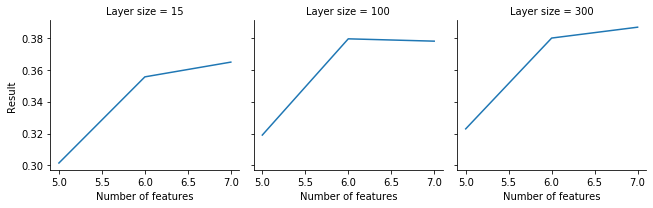

In [101]:
grid = sns.FacetGrid(pd.DataFrame(results_lbfgs), col="Layer size", col_wrap=4)
grid.map(plt.plot, "Number of features", "Result")

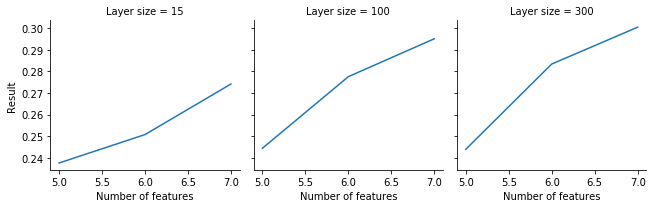

In [102]:
grid = sns.FacetGrid(pd.DataFrame(results_sgd), col="Layer size", col_wrap=4)
grid.map(plt.plot, "Number of features", "Result")

In [103]:
print(best_result)
print(best_classifier)
with np.printoptions(formatter={'float_kind':lambda x: "%2i" % x}):
    print(best_confusion_matrix)

    trues = np.diag(best_confusion_matrix)
    falses = np.sum(best_confusion_matrix, axis=1) - trues
    print(np.array((trues, falses)))

0.38682926829268294
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.0, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
[[32 12 28 15  5  5  0  1  1  4  4  4  1  4  0  1  0  3  0  0]
 [15 16 27  7  3  3  2  1  5  0  5  2  0  0  4  4  0  1  0  0]
 [25 14 45  6  2  0  9  2  9  0  9  5  0  1  4  3  0  1  0  0]
 [23  8  4 27 13  0  1  0  0  0  2  2  4  2  2  2  0  0  0  0]
 [11  2  5 15 46  0  0  0  0  0  2  4  7  2  7  8  0  0  0  1]
 [ 0  2  3  0  0 46 15  1  5  3  0  0  4  4  0  1  0  1  0  0]
 [ 0  0  1  1  0 16 56 12  0  3  2  5  7  5  1  1  0  0  0  0]
 [ 1  1  8

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

def verifyDummyClassifier(dataset, classes):
    classifier = DummyClassifier()
    cross_validator = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=7890)
    scores = []

    for train_index, test_index in cross_validator.split(dataset, classes):
        X_train, X_test = dataset[train_index, : ], dataset[test_index, : ]
        y_train, y_test = classes.loc[train_index], classes.loc[test_index]
        classifier.fit(X_train, y_train)
        predict = classifier.predict(X_test)
        acc_score = accuracy_score(y_test, predict)
        scores.append(acc_score)

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print("Accuracy score: %.3f (%.3f)" % (mean_score, std_score))
    return mean_score

In [ ]:
import warnings
warnings.filterwarnings('ignore')

dummyResults = []

for k in range(1, 21):
    train_set = SelectKBest(chi2, k=k).fit_transform(training_set, classes)
    dummyResults.append(verifyDummyClassifier(preprocessing.scale(train_set), classes))

print(max(dummyResults), sum(dummyResults)/len(dummyResults))